In [ ]:
#Install the necessary packages

!pip install wfdb wget
!pip install imbalanced-learn
!pip install py-ecg-detectors
!pip uninstall imgaug
!pip install imgaug==0.2.5
!pip uninstall matplotlib
!pip install matplotlib==3.4.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 28.0 MB/s 
     |████████████████████████████████| 11.2 MB 61.6 MB/s 
     |████████████████████████████████| 930 kB 50.3 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=806c56eaea29c1dfe6ff1e30b423aa52ee0868a63cd0424d774a7635978d5934
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 752 kB 23.8 MB/s 
     |████████████████████████████████| 554 kB 58.8 MB/s 
  Created wheel for py-ecg-detectors: filename=py_ecg_detectors-1.3.1-py3-none-any.whl size=25485 sha256=49c2b6dd3f3c550ce6ed033ea4368802f7385327be890b625e956867e8388c6d
  Stored in directory: /root/.cache/pip/wheels/a8/a4/37/490f98174f07b8f5d4069f03238a68f75e0cbfe30530437979
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=e564da9da40cd703f1ca9ddb17bcd2a138406cc77a70fbc6669f2f323bf54ecd
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built py-ecg-detectors gatspy
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3

In [ ]:
#Import the packages required

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from collections import Counter
from sklearn.preprocessing import LabelEncoder #tool for encoding the levels of categorical features into numeric values
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from ecgdetectors import Detectors

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls

Mounted at /content/gdrive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [ ]:
#drive.flush_and_unmount()

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/data.0.1")
!ls

example_physionet.py  ptbxl_database.csv  records100  scp_statements.csv
LICENSE.txt	      RECORDS		  records500  SHA256SUMS.txt


In [ ]:
# Method to collect and label the dataset
# dataset used -> ptbxl_database.csv 
#Function output : dataframe 'df'

#In pandas, the datastructure can be implemented using the dataframes with rows n columns
#The data from the csv file is read into the dataframe.


def dataset(dataset): 

 # First:  collect the superclass NORM and the MI records from the dataset.

    df = pd.read_csv(dataset) # Read the csv dataset file


    #SCP-ECG  (Standard communications protocol for computer assisted electrocardiography)
    #It addresses the ECG data and related metadata
    #In the dataset, we use the scp_codes column to collect the required data 

    # In the scp_codes column , to extract the data from position 1 from left after the symbol(')-> str.split("'").str[1]
    #For MI: to extract 2 char from the right onwards we use str[-2:]

    MI_class = df['scp_codes'].str.split("'").str[1].str[-2:]=='MI'  # collect all the MI class record.
   # print("MI Class:\n", MI_class)
   # print("----------------\n")
    NORM_class = df['scp_codes'].str.split("'").str[1]=='NORM'       # collect all the Normal class record.
  
    df = df [MI_class|NORM_class] # dataframe with MI and NORM classes
    df['class_label'] = df['scp_codes'].str.split("'").str[1]      # create a new column 'label' which would contain categorical labels given to the classes.
    
  #To aid the computation , we reduce the dataset by downsampling the classes with label  'NORM', 'IMI', and 'ASMI'.
  #Thus, we collect only 1000 records for each of these classes (randomly ) 
 
    # n = number of item to return
    # random_state = seed for random number generator

    class_norm = df[df['class_label'] == 'NORM']
    class_norm = class_norm.sample(n = 1000, random_state = 1)
    
    class_imi = df[df['class_label'] == 'IMI']
    class_imi = class_imi.sample(n = 1000, random_state = 1)
    
    class_asmi = df[df['class_label'] == 'ASMI']
    class_asmi = class_asmi.sample(n = 1000, random_state = 1)
    
    #Collect sub class data of the super class MI
    #The superclass MI , contains several sub category like LMI, AMI , ILMI , ALMI , IPMI , IPLMI, PMI 
    s0 = (df['class_label'] == 'LMI')
    s1 = (df['class_label'] == 'AMI')
    s2 = (df['class_label'] == 'ILMI')
    s3 = (df['class_label'] == 'ALMI')
    s4 = (df['class_label'] == 'IPMI')
    s5 = (df['class_label'] == 'IPLMI')
    s6 = (df['class_label'] == 'PMI')
    
    class_mi_subclass = df[s0|s1|s2|s3|s4|s5|s6] #Contains the sum of all MI subclass data records 
  
    df = pd.concat([class_norm, class_imi, class_asmi, class_mi_subclass], ignore_index = True) # Combine all the required data records in one dataframe dataset
    
    #frac:  it specifies the fraction of rows to return in the random sample, so frac=1 means to return all rows (in random order).
    #random_state:  is used as a seed to the random number generator. This ensures that the random numbers are generated in the same order.
    df = df.sample(frac = 1, random_state=42)
    
    return  df


In [ ]:
# Mounting the Google Drive and files to Google Colab
from google.colab import files
files.upload()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
dataset('ptbxl_database.csv').head() #head() by default prints the top 5 

In [ ]:
Counter(dataset('ptbxl_database.csv')['class_label'])
#This shows all the classes (with their amount) to classify (So, 10 in our case).

In [ ]:
# Histogram plot to show the frequency of each of the classes present in the dataset

data_dict = Counter(dataset('ptbxl_database.csv')['class_label'])
classes = data_dict.keys() # class name - x axis
values = data_dict.values() # frequency of record in the database - y axis

plt.bar(classes , values)

plt.xlabel("\nClass")
plt.ylabel("Number of records\n")
plt.title("Frequency of each class in the dataset \n ")

plt.show()

In [ ]:
# Method to divide and label the dataset
# parameter -> dataframe from the function dataset 
# Function output :
# X: numpy arrray data with columns ecgid n filename_hr
# Y: class name   

def div_and_label(dataframe):   # dataframe = df, function returns X and y (labelled).
    
    # does the one-hot encoding of the labels and assigns them numbers between 0 to 9.
    
    X = dataframe[['ecg_id', 'filename_hr']]   #using the higher sampling frequency-500 Hz
   # print("--------------------")
   # print("Value of X dataframe: \n")
   # print(X)
   # print("--------------------")
    X = X.to_numpy()

    y = dataframe['class_label'] # categorical classes 
    encoder = LabelEncoder()
    encoder.fit(y) # takes a categorical column(y) and converts/maps it to numerical values.
    # 'ALMI': 0, 'AMI': 1, 'ASMI': 2, 'ILMI': 3, 'IMI': 4, 'IPLMI': 5, 'IPMI': 6, 'LMI': 7, 'NORM': 8, 'PMI': 9
    encoded_y = encoder.transform(y)

    mapping = dict(zip(encoder.classes_, range(0, len(encoder.classes_)+1)))
   # print(mapping, encoded_y)
    #print("\n\n\n--------------------\n")
   
   # print("categorical classes : \n")
   # print(y)
   # print("--------------------")
   # print("Encoded Y: \n")
   # print(encoded_y)
   # print("--------------------")
   # print("Value of X in numpy: \n")
   # print(X)
   # print("--------------------")
    return (X, encoded_y)

In [ ]:
para = dataset('ptbxl_database.csv') 
div_and_label(para)

In [ ]:
# Method to balances the dataset; to make each class have 1000 instances.
# Parameter : # X= X data in numpy format , Y = encoded_y (classes)
# Function output : 
# X_del: numpy data with ecgid n filename_hr
# Y_del: class name 

def balance_dataset(X , Y):   
        
    smote_nc = SMOTENC(categorical_features=[1], random_state = 0)
    X_res, Y_del = smote_nc.fit_resample(X, Y)
    X_del = np.delete(X_res, 0, 1)
      
    return (X_del, Y_del)

In [ ]:
# collecting the values of input and target (obtained so far) in these variables as shown below, for further use.

alpha = dataset('ptbxl_database.csv')   # the database file is imported to the jupyter notebook itself.
beta0, beta1 = div_and_label(alpha)
gamma0, gamma1 = balance_dataset(beta0, beta1)

print(gamma0.shape) #X- signal 2D
print(gamma1.shape) #Y- label  1D

(10000, 1)
(10000,)


In [ ]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH OF THE CLASSES AFTER THE AUGMENTATION AND BALANCING(OVER SAMPLING)

my_dict1 = Counter(gamma1) # for Y
ab_class = my_dict1.keys()
values1 = my_dict1.values()


plt.xlabel("\nClass")
class_list = [ 'ALMI', 'AMI', 'ASMI', 'ILMI', 'IMI', 'IPLMI', 'IPMI', 'LMI' , 'NORM', 'PMI']
plt.xticks(range(0,10), class_list)

plt.ylabel("Number of records\n")
plt.title("Frequency of each class in the dataset \n")

plt.bar(ab_class, values1)

In [ ]:
def records_tt_split(Xin, yin):   # Xin = gamma0, yin = gamma1
    
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)    # 75%-25% split.
    
    skf.get_n_splits(Xin, yin)
    
    for train_index, test_index in skf.split(Xin, yin):
        X_train, X_test = Xin[train_index], Xin[test_index]
        y_train, y_test = yin[train_index], yin[test_index]
        #print("X train\n", X_train)
        #print("X test\n",X_test)
        #print("''''''''''''''''''''''''\n\n")
        #print("Y train\n",y_train)
        #print("Y test\n",y_test)
        #print("''''''''''''''''''''''''\n\n")

    return (X_train, X_test, y_train, y_test)

In [ ]:
print("X: ",gamma0)
print("Y:",gamma1)
print("\n\n---------------------\n\n")

records_tt_split(gamma0, gamma1)


In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
# intialize global lists
final_list_X = []  # would contain lists of all 36 features extracted from the ECG beats
final_list_y = []  # would contain corresponding labels to the beats (0-9)

def load_raw_data(feat_inp, targ_inp):
    #feat_inp = gamma0, ----#X- signal 2D
    #targ_inp = gamma1  ----#Y- label  1D
    
    path = '/content/gdrive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/data.0.1'
    temp = feat_inp
    new_arr = np.reshape(temp, temp.shape[0])    # reshaping gamma0 (X_del) to an 1D array to make 'in' command work well.
    
    record_no = 0
    
    for f in new_arr:
        signal, meta_val = wfdb.rdsamp(path + '/' + f)   # signal.shape = (5000, 12) , rdsamp - read WFDB signal files
        value = signal.T
        wfdb.plot_all_records()
        temp_list = []
        flag1 = -1
        
        for ind in range(12):
            val_ind = value[ind]
            tmpp = val_ind.shape[0]
            val_ind = val_ind.reshape(1, tmpp)
            val_filtered = filter_data(val_ind)
            val_filtered = val_filtered.reshape(val_filtered.shape[1] )  # converting (1, 5000) to (5000, ) i.e., 1-D array
           # print(val_filtered)       
            a_var = return_peaks(val_filtered)
                                 
            if(a_var == 'INCOMPLETE'):
                temp_list = []
                flag1 = 1
                break
            
            temp_list.append(a_var)
        
        
        if(flag1==-1):
            final_data_return(temp_list, targ_inp[record_no])
        
        record_no = record_no + 1

In [ ]:
def filter_data(val):
    
    ecg = val 
    Fs = 500  # sampling frequency of the ECG signal.
    N = ecg.shape[1]
    t = ((np.linspace(0, N-1, N))/(Fs))
    
    cover = t.shape[0]
    t = t.reshape(1, cover)   # t must be of the same shape as xn.
    n=2    # order of filter.

    Fcutoff_low = 0.5                # cut off the freq below 0.5 Hz 
    Wn_low = ((2*Fcutoff_low)/(Fs))  #critical freq
    b_low, a_low = signal.butter(n, Wn_low, 'low')  #butterworth filter
    xn_filtered_LF = signal.filtfilt(b_low, a_low, ecg)  #zero-phase digital filter

    Fcutoff_high = 40   # cut off the freq above 40 Hz 
    Wn_high = ((2*Fcutoff_high)/(Fs))   #critical freq
    b_high, a_high = signal.butter(n, Wn_high, 'high') #butterworth filter
    xn_filtered_HF = signal.filtfilt(b_high, a_high, ecg)  # zero-phase digital filter

    xn = (ecg-xn_filtered_HF-xn_filtered_LF)
    return xn

In [ ]:
#!pip uninstall neurokit
#0.1.6
!pip install neurokit2
!pip install biosppy

In [ ]:
import neurokit2 as nk
import biosppy

In [ ]:
biosppy.__version__


In [ ]:
nk.__version__

'0.2.0'

In [ ]:
def return_peaks(ecg_test):
    
    ''' clean the signal further with the neurokit '''

    cleaned = nk.ecg_clean(ecg_test, sampling_rate = 500)  


    ''' Detect the R-peaks for that lead '''

    rdet, = biosppy.signals.ecg.hamilton_segmenter(signal=cleaned, sampling_rate = 500)   # ECG R-peak segmentation algorithm.
    rdet, = biosppy.signals.ecg.correct_rpeaks(signal = cleaned, rpeaks = rdet, sampling_rate = 500, tol = 0.05)
    
    if(rdet.size<=4):        # when just 4 or less rpeaks are found, there's no point of considering that whole record at all.
      return 'INCOMPLETE'
    
    rdet = np.delete(rdet, -1)       # remove the last R-peak to avoid the invalid detection for S and T peaks.
    rdet = np.delete(rdet, 0)        # remove the first R-peak to avoid the invalid detection for P and Q peaks.
    rpeaks = {'ECG_R_Peaks': rdet}    # created this dictionary to use it for the future use.

    ''' remove the baseline wander from the ECG lead '''

    cleaned_base = nk.signal_detrend(cleaned, order=0)

    ''' The features to be extracted are Q-wave amplitude, T-wave amplitude, and ST deviation.
                   (a) ST-deviation = (value of cleaned_base at QRS onset - value of cleaned_base at QRS offset).
                   (b) T amplitude = value of cleaned_base at the position of T peak.
                   (c) Q amplitude = value of cleaned_base at the position of Q peak. '''


    ''' ECG delineation using 'dwt' method for (i) T-Peak detection, (ii) QRS wave onsets and offsets: '''

    signals, waves = nk.ecg.ecg_delineate(cleaned_base, rpeaks, sampling_rate = 500, method = "dwt" ) 


    ''' ECG delineation using 'peak' method for Q-Peak detection. '''

    ''' for the peak detection using 'peak' method, we must have atleast 4 R-Peaks otherwise it shows an
     error due to incompatibility and then we won't be able to extract the time domain features. In that case,
     either we remove the complete ECG record or we keep on appending the array for the rpeaks (rpeaks['ECG_R_Peaks']) with the 
     last rpeak position until it's size becomes atleast 4.'''

    rpeakss = rpeaks.copy()  #just store the rpeaks in some other variable. .copy() is used to prevent the similar changes in rpeaks
    temppo = 4-len(rpeakss['ECG_R_Peaks'])

    if temppo>0:

        for i in range(temppo):
            rpeakss['ECG_R_Peaks'] = np.append(rpeakss['ECG_R_Peaks'], rpeakss['ECG_R_Peaks'][-1] + 1)


    signals1, waves1 = nk.ecg_delineate(cleaned_base, rpeakss, sampling_rate = 500, method = "peak")

    # To get the original Q peaks' positions, we remove the irrelevant ones.
    if temppo>0:
        for j in range(temppo):
            waves1['ECG_Q_Peaks'] = waves1['ECG_Q_Peaks'][:-1] #remove the last element by slicing.(waves1['ECG_Q_Peaks'] is a list)
               
    return (cleaned_base, [waves['ECG_T_Peaks'], waves['ECG_R_Onsets'], waves['ECG_R_Offsets'], waves1['ECG_Q_Peaks']])

In [ ]:
# For an example, the 'waves' obtained from the function return_peaks would look like as shown below.

'''waves'''

In [ ]:
# For an example, the 'waves1' obtained from the function return_peaks would look like as shown below.

'''waves1'''

In [ ]:
def final_data_return(given_list, targ_inp_val):
    
    '''' This function takes a list of 12 leads of an ECG record after their peak detection and ecg delineation, and extracts out 
    the ECG beats with 36 morphological features on the basis of the given list'''
    
    
    # The length of all the lists obtained from one lead will be the same, but the length of two lists from two different leads 
    # may be different. So, we gotta find the minimum sized list, which would give an idea of the number of beats that we can 
    # keep in our dataset from one record.

    mini = 50;    # 'mini' would store the length of the minimum sized list present in the 'given_list'

    for check_index3 in range(12):
        for second_ind3 in range(4):
            mini = min(mini, len(given_list[check_index3][1][second_ind3]))


    # we will consider at max 16 beats for one record

    to_take = min(16, mini)  # to_take = no. of beats that we'll take from one record.

    for x in range(to_take):

        a_temp_list = []   # this list will contain the 36 morphological features extracted from a beat of each of the 12 leads.
        flag = -1
        
        for y in range(12):
            
            # if there is any 'NaN' value in any of the lists, we would ignore that entire corresponding beat. (so, break the loop and proceed for the next beat)
            
            if((np.isnan(given_list[y][1][1][x])) or (np.isnan(given_list[y][1][2][x])) or (np.isnan(given_list[y][1][3][x])) or (np.isnan(given_list[y][1][0][x]))):
                a_temp_list = []
                flag = 1
                break
            
            first_feat = given_list[y][0][int(given_list[y][1][1][x])] - given_list[y][0][int(given_list[y][1][2][x])]   # (value of cleaned_base(cleaned ECG signal) at R onset of beat-x - value of cleaned_base at R offset of beat-x).
            second_feat = given_list[y][0][int(given_list[y][1][3][x])]   # value of cleaned_base at Q Peak of beat-x (where x is the beat number)
            third_feat = given_list[y][0][int(given_list[y][1][0][x])]    # value of cleaned_base at T Peak of beat-x

            a_temp_list.append(first_feat)
            a_temp_list.append(second_feat)
            a_temp_list.append(third_feat)

        if(flag == -1):
            final_list_X.append(a_temp_list)
            final_list_y.append(targ_inp_val)

In [ ]:
# Calling the below function will fill the lists 'final_list_X' and 'final_list_y' => we will get final dataset with beats and
# their features extracted.

load_raw_data(gamma0, gamma1) 

In [ ]:
print(len(final_list_X))
print(len(final_list_y))
print(len(final_list_X[0]))

694
694
36


In [ ]:
Counter(final_list_y)

Counter({0: 37, 1: 69, 2: 210, 3: 111, 4: 353, 5: 6, 7: 26, 8: 391})

<BarContainer object of 8 artists>

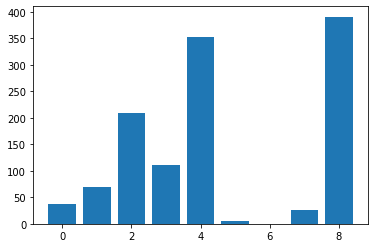

In [ ]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH CLASS AFTER EXTRACTING BEATS FROM ECG:

my_dict3 = Counter(final_list_y)
keys3 = my_dict3.keys()
values3 = my_dict3.values()

plt.bar(keys3, values3)

In [ ]:
class_list = {'ALMI':4515, 'AMI':3710, 'ASMI':3188, 'ILMI':3951, 'IMI':3876, 'IPLMI':3642, 'IPMI':2979, 'LMI':4448 , 'NORM':3131, 'PMI':4245}
bb_class = list(class_list.keys())
values2 = list(class_list.values())

plt.xlabel("\nClass")
plt.xticks(range(0,10), class_list)

plt.ylabel("Number of beats \n")
plt.title("Frequency of each class after extracting beats from ECG \n")

plt.bar(bb_class, values2)

In [ ]:
X_train_array = np.array(final_list_X)

In [ ]:
y_train_array = np.array(final_list_y)

In [ ]:
print(X_train_array.shape)
print(y_train_array.shape)

(1203, 36)
(1203,)


In [ ]:
# reshape the 2D training array into a 3D array before using neural networks.

X_train_array = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1)) 

In [ ]:
print(X_train_array.shape)
print(y_train_array.shape)

(1203, 36, 1)
(1203,)


In [ ]:
X_train, X_test, y_train, y_test = records_tt_split(X_train_array, y_train_array)  # train-test split of the overall data.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(903, 36, 1)
(300, 36, 1)
(903,)
(300,)


In [ ]:
# save these training and testing data as .npy files on the desktop.

path_to_store = '/content/gdrive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/data.0.1'

np.save(path_to_store + '/' + 'XTrain.npy', X_train)

In [ ]:
np.save(path_to_store + '/' + 'XTest.npy', X_test)
np.save(path_to_store + '/' + 'yTrain.npy', y_train)
np.save(path_to_store + '/' + 'yTest.npy', y_test)